In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer

# Data base import

In [2]:
from utils import sample_data

# -- Get the data -- #
NB_SAMPLES = 1000
TRAIN_SAMPLE = Path("../data/samples/sample_{}_train.csv".format(NB_SAMPLES))
VALID_SAMPLE = Path("../data/samples/sample_{}_validation.csv".format(NB_SAMPLES))
TRAIN_SAMPLE = pd.read_csv(TRAIN_SAMPLE).to_numpy()
VALID_SAMPLE = pd.read_csv(VALID_SAMPLE).to_numpy()


# -- Clean the data -- #
from utils.clean_data import clean_data
TRAIN_SAMPLE = clean_data(TRAIN_SAMPLE)
VALID_SAMPLE = clean_data(VALID_SAMPLE)

In [3]:
print(TRAIN_SAMPLE)

[['8fc8d9bd09' 'i feel really weird' 'weird' -1]
 ['7eea1e9cdf' 'Too many cocktails last night, my head hurts' 'hurts' -1]
 ['398128d145'
  'twice in a week Qantas club lounge computers broken  #flyertalk'
  'twice in a week Qantas club lounge computers broken  #flyertalk' 0]
 ...
 ['24ff960250' ' artery tomorrow. No more Hagen Daz for me'
  'artery tomorrow. No more Hagen Daz for me' 0]
 ['35b5a783cf'
  ' Here are some that other tweeple recommend to me: www.audiomicro.com , http://tr.im/gWOy , http://tr.im/gWPx'
  'Here are some that other tweeple recommend to me: www.audiomicro.com , http://tr.im/gWOy , http://tr.im/gWPx'
  0]
 ['1d1a84678c'
  'Getting ready to go to #Brighton to find myself a new suit from #GreshamBlake - Sunday = me time'
  'Getting ready to go to #Brighton to find myself a new suit from #GreshamBlake - Sunday = me time'
  0]]


# Pre-processing
#### TWEET_ORIGINALS : List of the tweets : Array, shape = (len(nb_tweets))
#### TWEET_STRINGS : List of the list of the word of each tweet : List of list of string
#### TWEET_SCALARS : List of the description of each tweet : Array, shape = (len(nb_tweets), sentence_size * word_size)
#### IMPORTANT_WORDS : List of the label of each tweet : Array, shape = (len(nb_tweets), sentence_size)

In [4]:
# -- Parameters -- #
WORD_SIZE = 50  # 50 or 100 or 200 or 300
FILL_WITH = 0  # If a word is not in the dictionary, [0, ..., 0] will describe it.
SENTIMENT_WEIGHT = 1  # Multiply the sentiment by a factor
SENTENCE_SIZE = 50  # What ever
OPTIONS = [WORD_SIZE, SENTENCE_SIZE, FILL_WITH, SENTIMENT_WEIGHT]


# -- Get the original tweets -- #
TWEET_ORIGINALS_TRAIN = TRAIN_SAMPLE[:, 1]
TWEET_ORIGINALS_VALID = VALID_SAMPLE[:, 1]
print("First tweet :")
print(TWEET_ORIGINALS_TRAIN[0])
print("Shape of TWEET_ORIGINAL :", TWEET_ORIGINALS_TRAIN.shape)

First tweet :
i feel really weird
Shape of TWEET_ORIGINAL : (966,)


In [5]:
from descriptors.tweet_string.create_strings import create_strings
from descriptors.tokenizer.tokenizer import Tokenizer

# Initialize the tokenizer
TOKENIZER = Tokenizer()

# -- Get the decomposition of the tweets -- #
TWEET_STRINGS_TRAIN = create_strings(TWEET_ORIGINALS_TRAIN, TOKENIZER, SENTENCE_SIZE)
TWEET_STRINGS_VALID = create_strings(TWEET_ORIGINALS_VALID, TOKENIZER, SENTENCE_SIZE)
print("Decomposition of the first tweet :")
print(TWEET_STRINGS_TRAIN[0])
print("Length of TWEET_STRING :", len(TWEET_STRINGS_TRAIN))

Decomposition of the first tweet :
['i', 'feel', 'really', 'weird']
Length of TWEET_STRING : 966


In [6]:
from descriptors.descriptor_glove.descriptor_glove import tweet_scalar_glove
from utils.standardize import standardize


# Get the dictionary
PATH_DICTIONARY = Path("../data/glove_descriptor/glove.6B.{}d.txt".format(WORD_SIZE))
# PATH_DICTIONARY = Path("../data/glove_descriptor/sample_test.txt")
DICTIONARY = pd.read_csv(PATH_DICTIONARY, sep=" ", header=None)

# Additional dictionary
ADDITIONAL_DIC = {"..": "...", "<3": "love"}

# Get the sentiments
SENTIMENTS_TRAIN = TRAIN_SAMPLE[:, -1]
SENTIMENTS_VALID = VALID_SAMPLE[:, -1]

# -- Get the decriptions of each tweets -- #
TWEET_SCALARS_TRAIN = tweet_scalar_glove(TWEET_STRINGS_TRAIN, SENTIMENTS_TRAIN, DICTIONARY, ADDITIONAL_DIC, OPTIONS)
TWEET_SCALARS_VALID = tweet_scalar_glove(TWEET_STRINGS_VALID, SENTIMENTS_VALID, DICTIONARY, ADDITIONAL_DIC, OPTIONS)

# Standardize the tweet descriptions
standardize(TWEET_SCALARS_TRAIN)
standardize(TWEET_SCALARS_VALID)

print("Description of the first tweet :")
print(TWEET_SCALARS_TRAIN[0])
print("Shape of TWEET_SCLALAR :", TWEET_SCALARS_TRAIN.shape)
print(TWEET_SCALARS_VALID.shape)

Description of the first tweet :
[ 0.13417587 -0.02395894 -0.21725474 ... -0.03219114 -0.03219114
 -1.        ]
Shape of TWEET_SCLALAR : (966, 2501)
(966, 2501)


In [7]:
from descriptors.tweet_label.create_labels import create_labels

# Create the decompositions of the labels
LABEL_ORIGINALS_TRAIN = TRAIN_SAMPLE[:, 2]
LABEL_ORIGINALS_VALID = VALID_SAMPLE[:, 2]
LABEL_STRINGS_TRAIN = create_strings(LABEL_ORIGINALS_TRAIN, TOKENIZER, SENTENCE_SIZE)
LABEL_STRINGS_VALID = create_strings(LABEL_ORIGINALS_VALID, TOKENIZER, SENTENCE_SIZE)

# -- Get the labels -- #
IMPORTANT_WORDS_TRAIN = create_labels(TWEET_STRINGS_TRAIN, LABEL_STRINGS_TRAIN, SENTENCE_SIZE)

IDX = 5
print(TWEET_ORIGINALS_TRAIN[IDX])
print(LABEL_ORIGINALS_TRAIN[IDX])
print("Labels :")
print(IMPORTANT_WORDS_TRAIN[IDX])
print("Shape of IMPORTANT_WORDS :", IMPORTANT_WORDS_TRAIN.shape)

 Can I have a splodge of ketchup on mine please?!
Can I have a splodge of ketchup on mine please?!
Labels :
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Shape of IMPORTANT_WORDS : (966, 50)


# Classification

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from utils.post_processing import preds_to_strings
from utils.loss import mean_jaccard

#### All the sentiments in the same Classifier

In [11]:
# --- Optimize the number of neighbors and the threshold --- #
# Parameter
NB_NEIGHBORS_MAX = 400
NB_NEIGHBORS_MIN = 20
STEP_NEIGH = 40
THRESHOLD_MAX = 1
THRESHOLD_MIN = 0
NB_THRESHOLDS = 15

# Variables
NB_NEIGHBORS_OPT = 1
THRESHOLD_OPT = 1
JACCARD_ACC_MAX = 0
JACCARD_LIST = []

# Modify the sentiments weigth
SENTIMENT_WEIGHT = 136
SCALARS_TRAIN = TWEET_SCALARS_TRAIN.copy()
SCALARS_TRAIN[:, -1] *= SENTIMENT_WEIGHT
SCALARS_VALID = TWEET_SCALARS_VALID.copy()
SCALARS_VALID[:, -1] *= SENTIMENT_WEIGHT


for nb_neigh in range(NB_NEIGHBORS_MIN, NB_NEIGHBORS_MAX, STEP_NEIGH):
    # Define the knn
    KNN = KNeighborsRegressor(nb_neigh, weights="distance")

    # Train the knn
    KNN.fit(SCALARS_TRAIN, IMPORTANT_WORDS_TRAIN)

    # Scalar predictions
    PRED_SCALAR = KNN.predict(SCALARS_VALID)
    for threshold in np.linspace(THRESHOLD_MIN, THRESHOLD_MAX, NB_THRESHOLDS):
        # Use the threshold
        PRED_SCALAR_THRESHOLD = PRED_SCALAR > threshold
        
        # Get the string predictions
        PRED_STRING = preds_to_strings(TWEET_ORIGINALS_VALID, TWEET_STRINGS_VALID, PRED_SCALAR_THRESHOLD)

        # Compute the loss
        JACCARD_ACC = mean_jaccard(LABEL_ORIGINALS_VALID, PRED_STRING)

        # Print results
        print("Jaccard score", JACCARD_ACC)
        print("Threshold", threshold)
        print("Number neighbors", nb_neigh)
        print("\n")
        
        # Updates
        JACCARD_LIST.append(JACCARD_ACC)
        if JACCARD_ACC > JACCARD_ACC_MAX:
            JACCARD_ACC_MAX = JACCARD_ACC
            NB_NEIGHBORS_OPT = nb_neigh    
            THRESHOLD_OPT = threshold

Jaccard score 0.44877374435550027
Threshold 0.0
Number neighbors 20


Jaccard score 0.41368371116473945
Threshold 0.07142857142857142
Number neighbors 20


Jaccard score 0.39459985327037983
Threshold 0.14285714285714285
Number neighbors 20


Jaccard score 0.36222423904201534
Threshold 0.21428571428571427
Number neighbors 20


Jaccard score 0.3495193065345161
Threshold 0.2857142857142857
Number neighbors 20


Jaccard score 0.32823236016495566
Threshold 0.3571428571428571
Number neighbors 20


Jaccard score 0.3077099909623779
Threshold 0.42857142857142855
Number neighbors 20


Jaccard score 0.27145406858702725
Threshold 0.5
Number neighbors 20


Jaccard score 0.2342190175438955
Threshold 0.5714285714285714
Number neighbors 20


Jaccard score 0.20063141742759497
Threshold 0.6428571428571428
Number neighbors 20


Jaccard score 0.14201745691521053
Threshold 0.7142857142857142
Number neighbors 20


Jaccard score 0.11662723113706704
Threshold 0.7857142857142857
Number neighbors 20


Jaccard s

Jaccard score 0.16211203613246492
Threshold 0.8571428571428571
Number neighbors 260


Jaccard score 0.1274658402961137
Threshold 0.9285714285714285
Number neighbors 260


Jaccard score 0.0
Threshold 1.0
Number neighbors 260


Jaccard score 0.5931507844903491
Threshold 0.0
Number neighbors 300


Jaccard score 0.5782688965286016
Threshold 0.07142857142857142
Number neighbors 300


Jaccard score 0.5500498089046527
Threshold 0.14285714285714285
Number neighbors 300


Jaccard score 0.5257508283779727
Threshold 0.21428571428571427
Number neighbors 300


Jaccard score 0.4956607647838046
Threshold 0.2857142857142857
Number neighbors 300


Jaccard score 0.43048152894395114
Threshold 0.3571428571428571
Number neighbors 300


Jaccard score 0.35356888488275684
Threshold 0.42857142857142855
Number neighbors 300


Jaccard score 0.2949729365665872
Threshold 0.5
Number neighbors 300


Jaccard score 0.2693049672215879
Threshold 0.5714285714285714
Number neighbors 300


Jaccard score 0.24607892159256922

The optimal number of neighbors to take is : 340
The optimal threshold is : 0.0
With this parameters, the Jaccard accuracy is : 0.5953751064509095


<IPython.core.display.Javascript object>


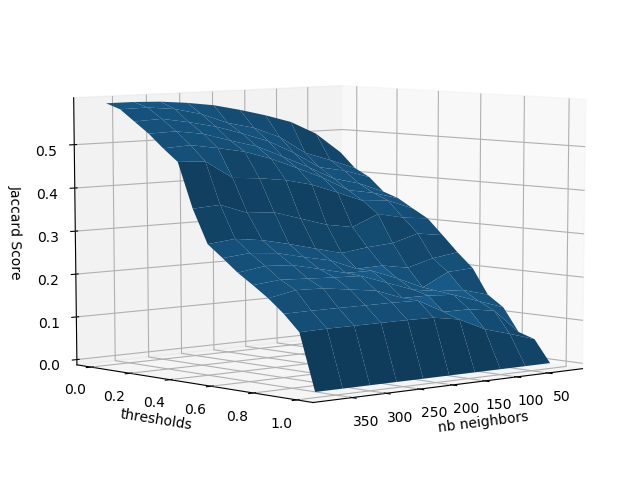

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Plot the results
PATH_SAVE = Path("../results")

print("The optimal number of neighbors to take is :", NB_NEIGHBORS_OPT)
print("The optimal threshold is :", THRESHOLD_OPT)
print("With this parameters, the Jaccard accuracy is :", JACCARD_ACC_MAX)

# Create the grid and the axes
LIST_NEIGHBORS = np.arange(NB_NEIGHBORS_MIN, NB_NEIGHBORS_MAX, STEP_NEIGH)
LIST_THRESHOLDS = np.linspace(THRESHOLD_MIN, THRESHOLD_MAX, NB_THRESHOLDS)
(NEIGHBORS, THRESHOLDS) = np.meshgrid(LIST_NEIGHBORS, LIST_THRESHOLDS)
ax = Axes3D(plt.figure())

# Show the plots
ax.plot_surface(NEIGHBORS, THRESHOLDS, np.reshape(JACCARD_LIST, (len(LIST_NEIGHBORS), -1)).T)
ax.set_xlabel('nb neighbors')
ax.set_ylabel('thresholds')
ax.set_zlabel('Jaccard Score')
plt.savefig(PATH_SAVE / "glove_knn_train_{}_neighbors_{}_nb_thresholds_{}.jpg".format(NB_SAMPLES, NB_NEIGHBORS_MAX, NB_THRESHOLDS))
plt.show()

#### Only neutral sentiments

In [13]:
# --- Optimize the number of neighbors and the weight sentiment --- #
# --- Only neutral sentiments --- #
# Parameter
NB_NEIGHBORS_MAX_NEUTRAL = 300
NB_NEIGHBORS_MIN_NEUTRAL = 5
STEP_NEIGH_NEUTRAL = 15
THRESHOLD_MAX_NEUTRAL = 1
THRESHOLD_MIN_NEUTRAL = 0
NB_THRESHOLDS_NEUTRAL = 15

# Variables
NB_NEIGHBORS_OPT_NEUTRAL = 1
THRESHOLD_OPT_NEUTRAL = 1
JACCARD_ACC_MAX_NEUTRAL = 0
JACCARD_LIST_NEUTRAL = []

# Select the neutral sentiments
TRAIN_SELECTION_NEUTRAL = np.where(TWEET_SCALARS_TRAIN[:, -1] == 0)
VALID_SELECTION_NEUTRAL = np.where(TWEET_SCALARS_VALID[:, -1] == 0)

TWEET_SCALARS_TRAIN_NEUTRAL = TWEET_SCALARS_TRAIN[TRAIN_SELECTION_NEUTRAL]
IMPORTANT_WORDS_TRAIN_NEUTRAL = IMPORTANT_WORDS_TRAIN[TRAIN_SELECTION_NEUTRAL]

TWEET_SCALARS_VALID_NEUTRAL = TWEET_SCALARS_VALID[VALID_SELECTION_NEUTRAL]
TWEET_ORIGINALS_VALID_NEUTRAL = TWEET_ORIGINALS_VALID[VALID_SELECTION_NEUTRAL]
TWEET_STRINGS_VALID_NEUTRAL = np.array(TWEET_STRINGS_VALID, dtype=object)[VALID_SELECTION_NEUTRAL]
LABEL_ORIGINALS_VALID_NEUTRAL = LABEL_ORIGINALS_VALID[VALID_SELECTION_NEUTRAL]


for nb_neigh in range(NB_NEIGHBORS_MIN_NEUTRAL, NB_NEIGHBORS_MAX_NEUTRAL, STEP_NEIGH_NEUTRAL):
    # Define the knn
    KNN = KNeighborsRegressor(nb_neigh, weights="distance")

    # Train the knn
    KNN.fit(TWEET_SCALARS_TRAIN_NEUTRAL, IMPORTANT_WORDS_TRAIN_NEUTRAL)

    # Scalar predictions
    PRED_SCALAR_NEUTRAL = KNN.predict(TWEET_SCALARS_VALID_NEUTRAL)
    
    for threshold in np.linspace(THRESHOLD_MIN, THRESHOLD_MAX, NB_THRESHOLDS):
        # Use threshold
        PRED_SCALAR_NEUTRAL_THRESHOLD = PRED_SCALAR_NEUTRAL > threshold
        
        # Get the string predictions
        PRED_STRING_NEUTRAL = preds_to_strings(TWEET_ORIGINALS_VALID_NEUTRAL, TWEET_STRINGS_VALID_NEUTRAL, PRED_SCALAR_NEUTRAL_THRESHOLD)

        # Compute the loss
        JACCARD_ACC_NEUTRAL = mean_jaccard(LABEL_ORIGINALS_VALID_NEUTRAL, PRED_STRING_NEUTRAL)

        # Print results
        print("Jaccard score", JACCARD_ACC_NEUTRAL)
        print("Threshold", threshold)
        print("Number neighbors", nb_neigh)
        print("\n")

        # Updates
        JACCARD_LIST_NEUTRAL.append(JACCARD_ACC_NEUTRAL)
        if JACCARD_ACC_NEUTRAL > JACCARD_ACC_MAX_NEUTRAL:
            JACCARD_ACC_MAX_NEUTRAL = JACCARD_ACC_NEUTRAL
            NB_NEIGHBORS_OPT_NEUTRAL = nb_neigh
            THRESHOLD_OPT_NEUTRAL = threshold

Jaccard score 0.5637874102458298
Threshold 0.0
Number neighbors 5


Jaccard score 0.5637874102458298
Threshold 0.07142857142857142
Number neighbors 5


Jaccard score 0.5612748474317594
Threshold 0.14285714285714285
Number neighbors 5


Jaccard score 0.4465883298185209
Threshold 0.21428571428571427
Number neighbors 5


Jaccard score 0.44293314915328996
Threshold 0.2857142857142857
Number neighbors 5


Jaccard score 0.4416768677462548
Threshold 0.3571428571428571
Number neighbors 5


Jaccard score 0.3457359112994592
Threshold 0.42857142857142855
Number neighbors 5


Jaccard score 0.34341340131363257
Threshold 0.5
Number neighbors 5


Jaccard score 0.3421571199065974
Threshold 0.5714285714285714
Number neighbors 5


Jaccard score 0.24817778865944196
Threshold 0.6428571428571428
Number neighbors 5


Jaccard score 0.2473163385517607
Threshold 0.7142857142857142
Number neighbors 5


Jaccard score 0.23830700617559422
Threshold 0.7857142857142857
Number neighbors 5


Jaccard score 0.1600638119

Jaccard score 0.8499298555547098
Threshold 0.0
Number neighbors 110


Jaccard score 0.7127585088828362
Threshold 0.07142857142857142
Number neighbors 110


Jaccard score 0.642984721840954
Threshold 0.14285714285714285
Number neighbors 110


Jaccard score 0.5987360873130967
Threshold 0.21428571428571427
Number neighbors 110


Jaccard score 0.5853455843501548
Threshold 0.2857142857142857
Number neighbors 110


Jaccard score 0.532524255265196
Threshold 0.3571428571428571
Number neighbors 110


Jaccard score 0.52608955716268
Threshold 0.42857142857142855
Number neighbors 110


Jaccard score 0.5259325219868006
Threshold 0.5
Number neighbors 110


Jaccard score 0.4713265176023456
Threshold 0.5714285714285714
Number neighbors 110


Jaccard score 0.43232173863095513
Threshold 0.6428571428571428
Number neighbors 110


Jaccard score 0.3936157046064645
Threshold 0.7142857142857142
Number neighbors 110


Jaccard score 0.3940960474973897
Threshold 0.7857142857142857
Number neighbors 110


Jaccard s

Jaccard score 0.9379998015873262
Threshold 0.0
Number neighbors 215


Jaccard score 0.857834535365214
Threshold 0.07142857142857142
Number neighbors 215


Jaccard score 0.8313854183571792
Threshold 0.14285714285714285
Number neighbors 215


Jaccard score 0.7957132499081132
Threshold 0.21428571428571427
Number neighbors 215


Jaccard score 0.7557737972473267
Threshold 0.2857142857142857
Number neighbors 215


Jaccard score 0.711691960518339
Threshold 0.3571428571428571
Number neighbors 215


Jaccard score 0.6728066335498941
Threshold 0.42857142857142855
Number neighbors 215


Jaccard score 0.624321079496957
Threshold 0.5
Number neighbors 215


Jaccard score 0.5835330498457563
Threshold 0.5714285714285714
Number neighbors 215


Jaccard score 0.5265726272751471
Threshold 0.6428571428571428
Number neighbors 215


Jaccard score 0.5168685278799451
Threshold 0.7142857142857142
Number neighbors 215


Jaccard score 0.44250326171466514
Threshold 0.7857142857142857
Number neighbors 215


Jaccard 

The optimal number of neighbors to take is : 290
The optimal threshold is : 0.0
With this parameters, the Jaccard accuracy is : 0.9654367695576584


<IPython.core.display.Javascript object>


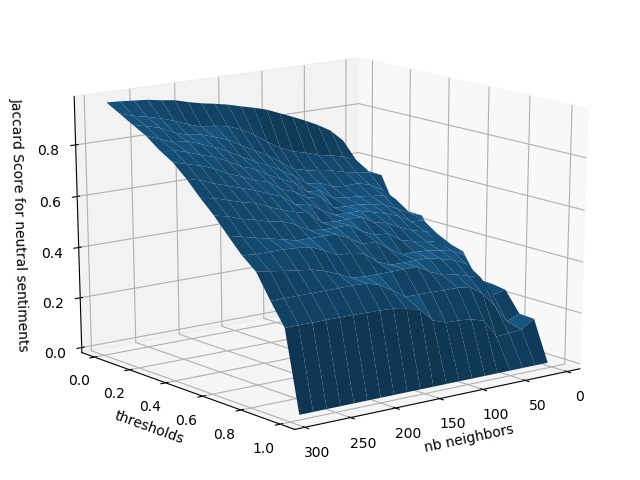

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Plot the results
PATH_SAVE = Path("../results")

print("The optimal number of neighbors to take is :", NB_NEIGHBORS_OPT_NEUTRAL)
print("The optimal threshold is :", THRESHOLD_OPT_NEUTRAL)
print("With this parameters, the Jaccard accuracy is :", JACCARD_ACC_MAX_NEUTRAL)

# Create the grid and the axes
LIST_NEIGHBORS_NEUTRAL = np.arange(NB_NEIGHBORS_MIN_NEUTRAL, NB_NEIGHBORS_MAX_NEUTRAL, STEP_NEIGH_NEUTRAL)
LIST_THRESHOLDS_NEUTRAL = np.linspace(THRESHOLD_MIN_NEUTRAL, THRESHOLD_MAX_NEUTRAL, NB_THRESHOLDS_NEUTRAL)
(NEIGHBORS_NEUTRAL, THRESHOLDS_NEUTRAL) = np.meshgrid(LIST_NEIGHBORS_NEUTRAL, LIST_THRESHOLDS_NEUTRAL)
ax = Axes3D(plt.figure())

# Show the plots
ax.plot_surface(NEIGHBORS_NEUTRAL, THRESHOLDS_NEUTRAL, np.reshape(JACCARD_LIST_NEUTRAL, (len(LIST_NEIGHBORS_NEUTRAL), -1)).T)
ax.set_xlabel('nb neighbors')
ax.set_ylabel('thresholds')
ax.set_zlabel('Jaccard Score for neutral sentiments')
plt.savefig(PATH_SAVE / "glove_knn_train_{}_neighbors_{}_nb_thresholds_{}_neutral.jpg".format(NB_SAMPLES, NB_NEIGHBORS_MAX_NEUTRAL, NB_THRESHOLDS_NEUTRAL))
plt.show()

#### Only positive sentiments

In [15]:
# --- Optimize the number of neighbors and the weight sentiment --- #
# --- Only positive sentiments --- #
# Parameter
NB_NEIGHBORS_MAX_POSITIVE = 300
NB_NEIGHBORS_MIN_POSITIVE = 5
STEP_NEIGH_POSITIVE = 15
THRESHOLD_MAX_POSITIVE = 1
THRESHOLD_MIN_POSITIVE = 0
NB_THRESHOLDS_POSITIVE = 15

# Variables
NB_NEIGHBORS_OPT_POSITIVE = 1
THRESHOLD_OPT_POSITIVE = 1
JACCARD_ACC_MAX_POSITIVE = 0
JACCARD_LIST_POSITIVE = []

# Select the positive sentiments
TRAIN_SELECTION_POSITIVE = np.where(TWEET_SCALARS_TRAIN[:, -1] == 1)
VALID_SELECTION_POSITIVE = np.where(TWEET_SCALARS_VALID[:, -1] == 1)

TWEET_SCALARS_TRAIN_POSITIVE = TWEET_SCALARS_TRAIN[TRAIN_SELECTION_POSITIVE]
IMPORTANT_WORDS_TRAIN_POSITIVE = IMPORTANT_WORDS_TRAIN[TRAIN_SELECTION_POSITIVE]

TWEET_SCALARS_VALID_POSITIVE = TWEET_SCALARS_VALID[VALID_SELECTION_POSITIVE]
TWEET_ORIGINALS_VALID_POSITIVE = TWEET_ORIGINALS_VALID[VALID_SELECTION_POSITIVE]
TWEET_STRINGS_VALID_POSITIVE = np.array(TWEET_STRINGS_VALID, dtype=object)[VALID_SELECTION_POSITIVE]
LABEL_ORIGINALS_VALID_POSITIVE = LABEL_ORIGINALS_VALID[VALID_SELECTION_POSITIVE]


for nb_neigh in range(NB_NEIGHBORS_MIN_POSITIVE, NB_NEIGHBORS_MAX_POSITIVE, STEP_NEIGH_POSITIVE):
    # Define the knn
    KNN = KNeighborsRegressor(nb_neigh, weights="distance")

    # Train the knn
    KNN.fit(TWEET_SCALARS_TRAIN_POSITIVE, IMPORTANT_WORDS_TRAIN_POSITIVE)

    # Scalar predictions
    PRED_SCALAR_POSITIVE = KNN.predict(TWEET_SCALARS_VALID_POSITIVE)
    
    for threshold in np.linspace(THRESHOLD_MIN, THRESHOLD_MAX, NB_THRESHOLDS):
        # Use the treshold
        PRED_SCALAR_POSITIVE_THRESHOLD = PRED_SCALAR_POSITIVE > threshold
        
        # Get the string predictions
        PRED_STRING_POSITIVE = preds_to_strings(TWEET_ORIGINALS_VALID_POSITIVE, TWEET_STRINGS_VALID_POSITIVE, PRED_SCALAR_POSITIVE_THRESHOLD)

        # Compute the loss
        JACCARD_ACC_POSITIVE = mean_jaccard(LABEL_ORIGINALS_VALID_POSITIVE, PRED_STRING_POSITIVE)

        # Print results
        print("Jaccard score", JACCARD_ACC_POSITIVE)
        print("Threshold", threshold)
        print("Number neighbors", nb_neigh)
        print("\n")

        # Updates
        JACCARD_LIST_POSITIVE.append(JACCARD_ACC_POSITIVE)
        if JACCARD_ACC_POSITIVE > JACCARD_ACC_MAX_POSITIVE:
            JACCARD_ACC_MAX_POSITIVE = JACCARD_ACC_POSITIVE
            NB_NEIGHBORS_OPT_POSITIVE = nb_neigh
            THRESHOLD_OPT_POSITIVE = threshold

Jaccard score 0.2660899568697556
Threshold 0.0
Number neighbors 5


Jaccard score 0.26620732776177447
Threshold 0.07142857142857142
Number neighbors 5


Jaccard score 0.27327473218833376
Threshold 0.14285714285714285
Number neighbors 5


Jaccard score 0.2631052664425697
Threshold 0.21428571428571427
Number neighbors 5


Jaccard score 0.2664307750497685
Threshold 0.2857142857142857
Number neighbors 5


Jaccard score 0.2681913384300503
Threshold 0.3571428571428571
Number neighbors 5


Jaccard score 0.24546832613006375
Threshold 0.42857142857142855
Number neighbors 5


Jaccard score 0.2408154086250336
Threshold 0.5
Number neighbors 5


Jaccard score 0.24134357763911812
Threshold 0.5714285714285714
Number neighbors 5


Jaccard score 0.19167061363105284
Threshold 0.6428571428571428
Number neighbors 5


Jaccard score 0.18973399391274298
Threshold 0.7142857142857142
Number neighbors 5


Jaccard score 0.16704228812244562
Threshold 0.7857142857142857
Number neighbors 5


Jaccard score 0.0734170

Jaccard score 0.31837941485420024
Threshold 0.0
Number neighbors 110


Jaccard score 0.29974951925947785
Threshold 0.07142857142857142
Number neighbors 110


Jaccard score 0.2902576051907802
Threshold 0.14285714285714285
Number neighbors 110


Jaccard score 0.28036035976939927
Threshold 0.21428571428571427
Number neighbors 110


Jaccard score 0.2549734168183838
Threshold 0.2857142857142857
Number neighbors 110


Jaccard score 0.23507648914649748
Threshold 0.3571428571428571
Number neighbors 110


Jaccard score 0.21350561146025115
Threshold 0.42857142857142855
Number neighbors 110


Jaccard score 0.17751233105934847
Threshold 0.5
Number neighbors 110


Jaccard score 0.015786384976525823
Threshold 0.5714285714285714
Number neighbors 110


Jaccard score 0.0
Threshold 0.6428571428571428
Number neighbors 110


Jaccard score 0.0
Threshold 0.7142857142857142
Number neighbors 110


Jaccard score 0.0
Threshold 0.7857142857142857
Number neighbors 110


Jaccard score 0.0
Threshold 0.8571428571428

Jaccard score 0.17776784591663802
Threshold 0.42857142857142855
Number neighbors 215


Jaccard score 0.017605633802816902
Threshold 0.5
Number neighbors 215


Jaccard score 0.0
Threshold 0.5714285714285714
Number neighbors 215


Jaccard score 0.0
Threshold 0.6428571428571428
Number neighbors 215


Jaccard score 0.0
Threshold 0.7142857142857142
Number neighbors 215


Jaccard score 0.0
Threshold 0.7857142857142857
Number neighbors 215


Jaccard score 0.0
Threshold 0.8571428571428571
Number neighbors 215


Jaccard score 0.0
Threshold 0.9285714285714285
Number neighbors 215


Jaccard score 0.0
Threshold 1.0
Number neighbors 215


Jaccard score 0.328522841346439
Threshold 0.0
Number neighbors 230


Jaccard score 0.3188768126081443
Threshold 0.07142857142857142
Number neighbors 230


Jaccard score 0.29758277658546944
Threshold 0.14285714285714285
Number neighbors 230


Jaccard score 0.27884250797192867
Threshold 0.21428571428571427
Number neighbors 230


Jaccard score 0.25359011701959105
Thr

The optimal number of neighbors to take is : 290
The optimal threshold is : 0.0
With this parameters, the Jaccard accuracy is : 0.3304103271073822


<IPython.core.display.Javascript object>


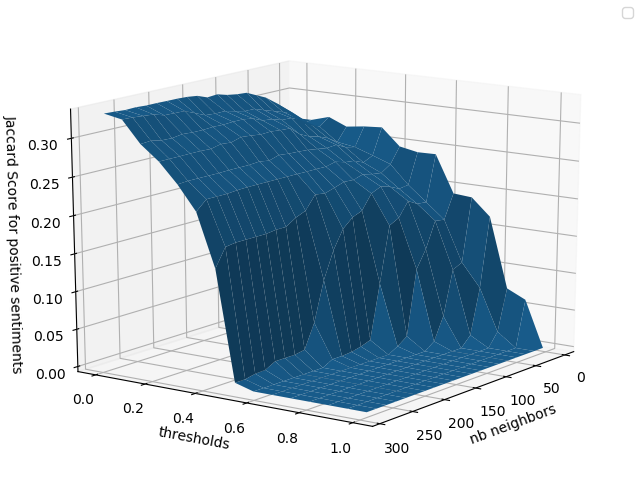

No handles with labels found to put in legend.


In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Plot the results
PATH_SAVE = Path("../results")

print("The optimal number of neighbors to take is :", NB_NEIGHBORS_OPT_POSITIVE)
print("The optimal threshold is :", THRESHOLD_OPT_POSITIVE)
print("With this parameters, the Jaccard accuracy is :", JACCARD_ACC_MAX_POSITIVE)

# Create the grid and the axes
LIST_NEIGHBORS_POSITIVE = np.arange(NB_NEIGHBORS_MIN_POSITIVE, NB_NEIGHBORS_MAX_POSITIVE, STEP_NEIGH_POSITIVE)
LIST_THRESHOLDS_POSITIVE = np.linspace(THRESHOLD_MIN_POSITIVE, THRESHOLD_MAX_POSITIVE, NB_THRESHOLDS_POSITIVE)
(NEIGHBORS_POSITIVE, THRESHOLDS_POSITIVE) = np.meshgrid(LIST_NEIGHBORS_POSITIVE, LIST_THRESHOLDS_POSITIVE)
ax = Axes3D(plt.figure())

# Show the plots
ax.plot_surface(NEIGHBORS_POSITIVE, THRESHOLDS_POSITIVE, np.reshape(JACCARD_LIST_POSITIVE, (len(LIST_NEIGHBORS_POSITIVE), -1)).T)
ax.set_xlabel('nb neighbors')
ax.set_ylabel('thresholds')
ax.set_zlabel('Jaccard Score for positive sentiments')
plt.legend()
plt.savefig(PATH_SAVE / "glove_knn_train_{}_neighbors_{}_nb_thresholds_{}_positive.jpg".format(NB_SAMPLES, NB_NEIGHBORS_MAX_POSITIVE, NB_THRESHOLDS_POSITIVE))
plt.show()

#### Only negative sentiments

In [17]:
# --- Optimize the number of neighbors and the weight sentiment --- #
# --- Only negative sentiments --- #
# Parameter
NB_NEIGHBORS_MAX_NEGATIVE = 300
NB_NEIGHBORS_MIN_NEGATIVE = 5
STEP_NEIGH_NEGATIVE = 15
THRESHOLD_MAX_NEGATIVE = 1
THRESHOLD_MIN_NEGATIVE = 0
NB_THRESHOLDS_NEGATIVE = 15

# Variables
NB_NEIGHBORS_OPT_NEGATIVE = 1
THRESHOLD_OPT_NEGATIVE = 1
JACCARD_ACC_MAX_NEGATIVE = 0
JACCARD_LIST_NEGATIVE = []

# Select the negative sentiments
TRAIN_SELECTION_NEGATIVE = np.where(TWEET_SCALARS_TRAIN[:, -1] == -1)
VALID_SELECTION_NEGATIVE = np.where(TWEET_SCALARS_VALID[:, -1] == -1)

TWEET_SCALARS_TRAIN_NEGATIVE = TWEET_SCALARS_TRAIN[TRAIN_SELECTION_NEGATIVE]
IMPORTANT_WORDS_TRAIN_NEGATIVE = IMPORTANT_WORDS_TRAIN[TRAIN_SELECTION_NEGATIVE]

TWEET_SCALARS_VALID_NEGATIVE = TWEET_SCALARS_VALID[VALID_SELECTION_NEGATIVE]
TWEET_ORIGINALS_VALID_NEGATIVE = TWEET_ORIGINALS_VALID[VALID_SELECTION_NEGATIVE]
TWEET_STRINGS_VALID_NEGATIVE = np.array(TWEET_STRINGS_VALID, dtype=object)[VALID_SELECTION_NEGATIVE]
LABEL_ORIGINALS_VALID_NEGATIVE = LABEL_ORIGINALS_VALID[VALID_SELECTION_NEGATIVE]


for nb_neigh in range(NB_NEIGHBORS_MIN_NEGATIVE, NB_NEIGHBORS_MAX_NEGATIVE, STEP_NEIGH_NEGATIVE):
    # Define the knn
    KNN = KNeighborsRegressor(nb_neigh, weights="distance")

    # Train the knn
    KNN.fit(TWEET_SCALARS_TRAIN_NEGATIVE, IMPORTANT_WORDS_TRAIN_NEGATIVE)

    # Scalar predictions
    PRED_SCALAR_NEGATIVE = KNN.predict(TWEET_SCALARS_VALID_NEGATIVE)
    
    for threshold in np.linspace(THRESHOLD_MIN, THRESHOLD_MAX, NB_THRESHOLDS):
        # Use threshold
        PRED_SCALAR_NEGATIVE_THRESHOLD = PRED_SCALAR_NEGATIVE > threshold

        # Get the string predictions
        PRED_STRING_NEGATIVE = preds_to_strings(TWEET_ORIGINALS_VALID_NEGATIVE, TWEET_STRINGS_VALID_NEGATIVE, PRED_SCALAR_NEGATIVE_THRESHOLD)

        # Compute the loss
        JACCARD_ACC_NEGATIVE = mean_jaccard(LABEL_ORIGINALS_VALID_NEGATIVE, PRED_STRING_NEGATIVE)

        # Print results
        print("Jaccard score", JACCARD_ACC_NEGATIVE)
        print("Threshold", threshold)
        print("Number neighbors", nb_neigh)
        print("\n")

        # Updates
        JACCARD_LIST_NEGATIVE.append(JACCARD_ACC_NEGATIVE)
        if JACCARD_ACC_NEGATIVE > JACCARD_ACC_MAX_NEGATIVE:
            JACCARD_ACC_MAX_NEGATIVE = JACCARD_ACC_NEGATIVE
            NB_NEIGHBORS_OPT_NEGATIVE = nb_neigh
            THRESHOLD_OPT_NEGATIVE = threshold

Jaccard score 0.2700144863916125
Threshold 0.0
Number neighbors 5


Jaccard score 0.2722054097092964
Threshold 0.07142857142857142
Number neighbors 5


Jaccard score 0.27723279625076747
Threshold 0.14285714285714285
Number neighbors 5


Jaccard score 0.24115445971032737
Threshold 0.21428571428571427
Number neighbors 5


Jaccard score 0.23141267567276877
Threshold 0.2857142857142857
Number neighbors 5


Jaccard score 0.23317323905305049
Threshold 0.3571428571428571
Number neighbors 5


Jaccard score 0.17026064125835752
Threshold 0.42857142857142855
Number neighbors 5


Jaccard score 0.16908693233816974
Threshold 0.5
Number neighbors 5


Jaccard score 0.1682066506480289
Threshold 0.5714285714285714
Number neighbors 5


Jaccard score 0.10572902706495671
Threshold 0.6428571428571428
Number neighbors 5


Jaccard score 0.10220790030439332
Threshold 0.7142857142857142
Number neighbors 5


Jaccard score 0.09371549852529772
Threshold 0.7857142857142857
Number neighbors 5


Jaccard score 0.03757

Jaccard score 0.31380595666614264
Threshold 0.0
Number neighbors 125


Jaccard score 0.2978510959147903
Threshold 0.07142857142857142
Number neighbors 125


Jaccard score 0.28186560995015675
Threshold 0.14285714285714285
Number neighbors 125


Jaccard score 0.25666605883410665
Threshold 0.21428571428571427
Number neighbors 125


Jaccard score 0.25477013735282406
Threshold 0.2857142857142857
Number neighbors 125


Jaccard score 0.23042145131404684
Threshold 0.3571428571428571
Number neighbors 125


Jaccard score 0.09951446769792485
Threshold 0.42857142857142855
Number neighbors 125


Jaccard score 0.0013590313812700766
Threshold 0.5
Number neighbors 125


Jaccard score 0.0
Threshold 0.5714285714285714
Number neighbors 125


Jaccard score 0.0
Threshold 0.6428571428571428
Number neighbors 125


Jaccard score 0.0
Threshold 0.7142857142857142
Number neighbors 125


Jaccard score 0.0
Threshold 0.7857142857142857
Number neighbors 125


Jaccard score 0.0
Threshold 0.8571428571428571
Number nei

Jaccard score 0.32512496682874775
Threshold 0.0
Number neighbors 245


Jaccard score 0.310520406996182
Threshold 0.07142857142857142
Number neighbors 245


Jaccard score 0.2939523142077455
Threshold 0.14285714285714285
Number neighbors 245


Jaccard score 0.2673854897574182
Threshold 0.21428571428571427
Number neighbors 245


Jaccard score 0.2502915112100022
Threshold 0.2857142857142857
Number neighbors 245


Jaccard score 0.15157621452831724
Threshold 0.3571428571428571
Number neighbors 245


Jaccard score 0.0
Threshold 0.42857142857142855
Number neighbors 245


Jaccard score 0.0
Threshold 0.5
Number neighbors 245


Jaccard score 0.0
Threshold 0.5714285714285714
Number neighbors 245


Jaccard score 0.0
Threshold 0.6428571428571428
Number neighbors 245


Jaccard score 0.0
Threshold 0.7142857142857142
Number neighbors 245


Jaccard score 0.0
Threshold 0.7857142857142857
Number neighbors 245


Jaccard score 0.0
Threshold 0.8571428571428571
Number neighbors 245


Jaccard score 0.0
Thresho

The optimal number of neighbors to take is : 290
The optimal threshold is : 0.0
With this parameters, the Jaccard accuracy is : 0.3272137681250705


<IPython.core.display.Javascript object>


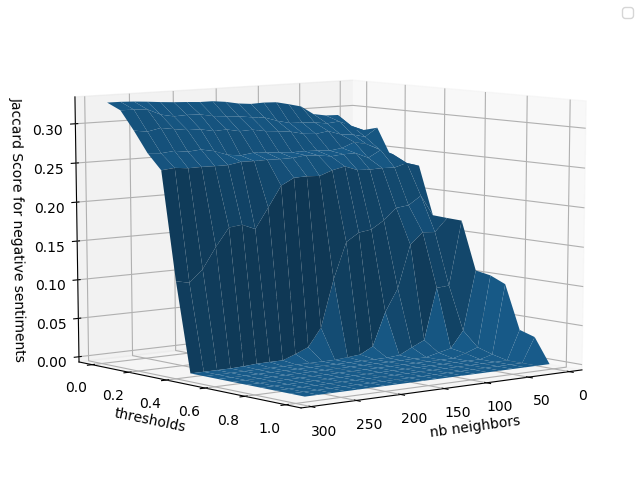

No handles with labels found to put in legend.


In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Plot the results
PATH_SAVE = Path("../results")

print("The optimal number of neighbors to take is :", NB_NEIGHBORS_OPT_NEGATIVE)
print("The optimal threshold is :", THRESHOLD_OPT_NEGATIVE)
print("With this parameters, the Jaccard accuracy is :", JACCARD_ACC_MAX_NEGATIVE)

# Create the grid and the axes
LIST_NEIGHBORS_NEGATIVE = np.arange(NB_NEIGHBORS_MIN_NEGATIVE, NB_NEIGHBORS_MAX_NEGATIVE, STEP_NEIGH_NEGATIVE)
LIST_THRESHOLDS_NEGATIVE = np.linspace(THRESHOLD_MIN_NEGATIVE, THRESHOLD_MAX_NEGATIVE, NB_THRESHOLDS_NEGATIVE)
(NEIGHBORS_NEGATIVE, THRESHOLDS_NEGATIVE) = np.meshgrid(LIST_NEIGHBORS_NEGATIVE, LIST_THRESHOLDS_NEGATIVE)
ax = Axes3D(plt.figure())

# Show the plots
ax.plot_surface(NEIGHBORS_NEGATIVE, THRESHOLDS_NEGATIVE, np.reshape(JACCARD_LIST_NEGATIVE, (len(LIST_NEIGHBORS_NEGATIVE), -1)).T)
ax.set_xlabel('nb neighbors')
ax.set_ylabel('thresholds')
ax.set_zlabel('Jaccard Score for negative sentiments')
plt.legend()
plt.savefig(PATH_SAVE / "glove_knn_train_{}_neighbors_{}_nb_thresholds_{}_negative.jpg".format(NB_SAMPLES, NB_NEIGHBORS_MAX_NEGATIVE, NB_THRESHOLDS_NEGATIVE))
plt.show()

#### Positive and negative sentiment in the same classifier

In [39]:
# --- Optimize the number of neighbors and the threshold sentiment --- #
# --- Positive and negative sentiments --- #
# Parameter
NB_NEIGHBORS_MAX_POS_NEG = 300
NB_NEIGHBORS_MIN_POS_NEG = 5
STEP_NEIGH_POS_NEG = 15
THRESHOLD_MAX_POS_NEG = 1
THRESHOLD_MIN_POS_NEG = 0
NB_THRESHOLDS_POS_NEG = 15

# Variables
NB_NEIGHBORS_OPT_POS_NEG = 1
THRESHOLD_OPT_POS_NEG = 1
JACCARD_ACC_MAX_POS_NEG = 0
JACCARD_LIST_POS_NEG = []

# Select the positive and the negative sentiments
TRAIN_SELECTION_POS = np.where(TWEET_SCALARS_TRAIN[:, -1] == 1)[0]
TRAIN_SELECTION_NEG = np.where(TWEET_SCALARS_TRAIN[:, -1] == -1)[0]
TRAIN_SELECTION_POS_NEG = np.concatenate((TRAIN_SELECTION_POS, TRAIN_SELECTION_NEG))
                                         
VALID_SELECTION_POS = np.where(TWEET_SCALARS_VALID[:, -1] == 1)[0]
VALID_SELECTION_NEG = np.where(TWEET_SCALARS_VALID[:, -1] == -1)[0]
VALID_SELECTION_POS_NEG = np.concatenate((VALID_SELECTION_POS, VALID_SELECTION_NEG))

TWEET_SCALARS_TRAIN_POS_NEG = TWEET_SCALARS_TRAIN[TRAIN_SELECTION_POS_NEG]
IMPORTANT_WORDS_TRAIN_POS_NEG = IMPORTANT_WORDS_TRAIN[TRAIN_SELECTION_POS_NEG]

TWEET_SCALARS_VALID_POS_NEG = TWEET_SCALARS_VALID[VALID_SELECTION_POS_NEG]
TWEET_ORIGINALS_VALID_POS_NEG = TWEET_ORIGINALS_VALID[VALID_SELECTION_POS_NEG]
TWEET_STRINGS_VALID_POS_NEG = np.array(TWEET_STRINGS_VALID, dtype=object)[VALID_SELECTION_POS_NEG]
LABEL_ORIGINALS_VALID_POS_NEG = LABEL_ORIGINALS_VALID[VALID_SELECTION_POS_NEG]

# Modify the sentiments weigth
SENTIMENT_WEIGHT = 61
TWEET_SCALARS_TRAIN_POS_NEG = TWEET_SCALARS_TRAIN_POS_NEG.copy()
TWEET_SCALARS_TRAIN_POS_NEG[:, -1] *= SENTIMENT_WEIGHT
TWEET_SCALARS_VALID_POS_NEG = TWEET_SCALARS_VALID_POS_NEG.copy()
TWEET_SCALARS_VALID_POS_NEG[:, -1] *= SENTIMENT_WEIGHT


for nb_neigh in range(NB_NEIGHBORS_MIN_POS_NEG, NB_NEIGHBORS_MAX_POS_NEG, STEP_NEIGH_POS_NEG):
    # Define the knn
    KNN = KNeighborsRegressor(nb_neigh, weights="distance")

    # Train the knn
    KNN.fit(TWEET_SCALARS_TRAIN_POS_NEG, IMPORTANT_WORDS_TRAIN_POS_NEG)

    # Scalar predictions
    PRED_SCALAR_POS_NEG = KNN.predict(TWEET_SCALARS_VALID_POS_NEG)
    
    for threshold in np.linspace(THRESHOLD_MIN, THRESHOLD_MAX, NB_THRESHOLDS):
        # Use threshold
        PRED_SCALAR_POS_NEG_THRESHOLD = PRED_SCALAR_POS_NEG > threshold
        
        # Get the string predictions
        PRED_STRING_POS_NEG = preds_to_strings(TWEET_ORIGINALS_VALID_POS_NEG, TWEET_STRINGS_VALID_POS_NEG, PRED_SCALAR_POS_NEG_THRESHOLD)

        # Compute the loss
        JACCARD_ACC_POS_NEG = mean_jaccard(LABEL_ORIGINALS_VALID_POS_NEG, PRED_STRING_POS_NEG)

        # Print results
        print("Jaccard score", JACCARD_ACC_POS_NEG)
        print("Threshold", threshold)
        print("Number neighbors", nb_neigh)
        print("\n")

        # Updates
        JACCARD_LIST_POS_NEG.append(JACCARD_ACC_POS_NEG)
        if JACCARD_ACC_POS_NEG > JACCARD_ACC_MAX_POS_NEG:
            JACCARD_ACC_MAX_POS_NEG = JACCARD_ACC_POS_NEG
            NB_NEIGHBORS_OPT_POS_NEG = nb_neigh
            THRESHOLD_OPT_POS_NEG = threshold

Jaccard score 0.26805222163068376
Threshold 0.0
Number neighbors 5


Jaccard score 0.2692063687355351
Threshold 0.07142857142857142
Number neighbors 5


Jaccard score 0.27525376421955033
Threshold 0.14285714285714285
Number neighbors 5


Jaccard score 0.25212986307644847
Threshold 0.21428571428571427
Number neighbors 5


Jaccard score 0.24892172536126858
Threshold 0.2857142857142857
Number neighbors 5


Jaccard score 0.25068228874155024
Threshold 0.3571428571428571
Number neighbors 5


Jaccard score 0.2078644836942105
Threshold 0.42857142857142855
Number neighbors 5


Jaccard score 0.20495117048160152
Threshold 0.5
Number neighbors 5


Jaccard score 0.20477511414357338
Threshold 0.5714285714285714
Number neighbors 5


Jaccard score 0.1486998203480048
Threshold 0.6428571428571428
Number neighbors 5


Jaccard score 0.14597094710856817
Threshold 0.7142857142857142
Number neighbors 5


Jaccard score 0.1303788933238717
Threshold 0.7857142857142857
Number neighbors 5


Jaccard score 0.055493

Jaccard score 0.3164269416690906
Threshold 0.0
Number neighbors 110


Jaccard score 0.2961155911826693
Threshold 0.07142857142857142
Number neighbors 110


Jaccard score 0.28520343672956244
Threshold 0.14285714285714285
Number neighbors 110


Jaccard score 0.2686212245429585
Threshold 0.21428571428571427
Number neighbors 110


Jaccard score 0.2541270336587811
Threshold 0.2857142857142857
Number neighbors 110


Jaccard score 0.23572995923447268
Threshold 0.3571428571428571
Number neighbors 110


Jaccard score 0.1797493552897056
Threshold 0.42857142857142855
Number neighbors 110


Jaccard score 0.09015843881853018
Threshold 0.5
Number neighbors 110


Jaccard score 0.007893192488262911
Threshold 0.5714285714285714
Number neighbors 110


Jaccard score 0.0
Threshold 0.6428571428571428
Number neighbors 110


Jaccard score 0.0
Threshold 0.7142857142857142
Number neighbors 110


Jaccard score 0.0
Threshold 0.7857142857142857
Number neighbors 110


Jaccard score 0.0
Threshold 0.8571428571428571

Jaccard score 0.32605056891938333
Threshold 0.0
Number neighbors 230


Jaccard score 0.3130029187216336
Threshold 0.07142857142857142
Number neighbors 230


Jaccard score 0.2945672201576424
Threshold 0.14285714285714285
Number neighbors 230


Jaccard score 0.2738531656195163
Threshold 0.21428571428571427
Number neighbors 230


Jaccard score 0.2517647577767684
Threshold 0.2857142857142857
Number neighbors 230


Jaccard score 0.2046749570544962
Threshold 0.3571428571428571
Number neighbors 230


Jaccard score 0.08923603563437535
Threshold 0.42857142857142855
Number neighbors 230


Jaccard score 0.008802816901408451
Threshold 0.5
Number neighbors 230


Jaccard score 0.0
Threshold 0.5714285714285714
Number neighbors 230


Jaccard score 0.0
Threshold 0.6428571428571428
Number neighbors 230


Jaccard score 0.0
Threshold 0.7142857142857142
Number neighbors 230


Jaccard score 0.0
Threshold 0.7857142857142857
Number neighbors 230


Jaccard score 0.0
Threshold 0.8571428571428571
Number neighbor

The optimal number of neighbors to take is : 290
The optimal threshold is : 0.0
With this parameters, the Jaccard accuracy is : 0.32881204761622607


<IPython.core.display.Javascript object>


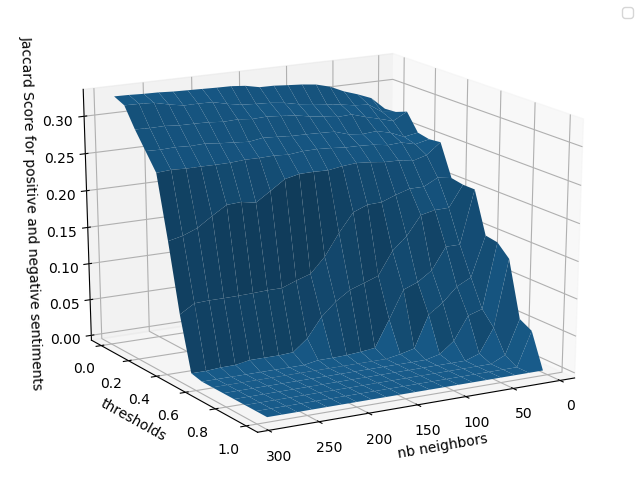

No handles with labels found to put in legend.


In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Plot the results
PATH_SAVE = Path("../results")

print("The optimal number of neighbors to take is :", NB_NEIGHBORS_OPT_POS_NEG)
print("The optimal threshold is :", THRESHOLD_OPT_POS_NEG)
print("With this parameters, the Jaccard accuracy is :", JACCARD_ACC_MAX_POS_NEG)

# Create the grid and the axes
LIST_NEIGHBORS_POS_NEG = np.arange(NB_NEIGHBORS_MIN_POS_NEG, NB_NEIGHBORS_MAX_POS_NEG, STEP_NEIGH_POS_NEG)
LIST_THRESHOLDS_POS_NEG = np.linspace(THRESHOLD_MIN_POS_NEG, THRESHOLD_MAX_POS_NEG, NB_THRESHOLDS_POS_NEG)
(NEIGHBORS_POS_NEG, THRESHOLDS_POS_NEG) = np.meshgrid(LIST_NEIGHBORS_POS_NEG, LIST_THRESHOLDS_POS_NEG)
ax = Axes3D(plt.figure())

# Show the plots
ax.plot_surface(NEIGHBORS_POS_NEG, THRESHOLDS_POS_NEG, np.reshape(JACCARD_LIST_POS_NEG, (len(LIST_NEIGHBORS_POS_NEG), -1)).T)
ax.set_xlabel('nb neighbors')
ax.set_ylabel('thresholds')
ax.set_zlabel('Jaccard Score for positive and negative sentiments')
plt.legend()
plt.savefig(PATH_SAVE / "glove_knn_train_{}_neighbors_{}_nb_thresholds_{}_pos_neg.jpg".format(NB_SAMPLES, NB_NEIGHBORS_MAX_POS_NEG, NB_THRESHOLDS_POS_NEG))
plt.show()

### Compute borderies

In [26]:
# - For Upper bound - # Take the real label with our functions
IMPORTANT_WORDS_VALID = create_labels(TWEET_STRINGS_VALID, LABEL_STRINGS_VALID, SENTENCE_SIZE)
PRED_STRING_UPPER = preds_to_strings(TWEET_ORIGINALS_VALID, TWEET_STRINGS_VALID, IMPORTANT_WORDS_VALID)

# - For Lower bound - # Keep every word
EVERY_WORD = np.zeros(IMPORTANT_WORDS_VALID.shape)
NB_TWEET_VALID = len(IMPORTANT_WORDS_VALID)
for idx_tweet in range(NB_TWEET_VALID):
    nb_words_tweet = len(TWEET_STRINGS_VALID[idx_tweet])
    EVERY_WORD[idx_tweet, : nb_words_tweet] = 1
PRED_STRING_LOWER = preds_to_strings(TWEET_ORIGINALS_VALID, TWEET_STRINGS_VALID, EVERY_WORD)

In [41]:
# --- All the sentiments in the same classifier --- #
# - Lower bound - #
JACCARD_ACC_LOWER = mean_jaccard(LABEL_ORIGINALS_VALID, PRED_STRING_LOWER)
print("The trivial solution for the classifier with all the sentiments is", JACCARD_ACC_LOWER)

# - Upper bound - #
JACCARD_ACC_UPPER = mean_jaccard(LABEL_ORIGINALS_VALID, PRED_STRING_UPPER)
print("The upper bound for the classifier with all the sentiments is", JACCARD_ACC_UPPER)


# --- Only neutral sentiments --- #
VALID_SELECTION_NEUTRAL = np.where(TWEET_SCALARS_VALID[:, -1] == 0)
# - Lower bound - #
JACCARD_ACC_LOWER_NEUTRAL = mean_jaccard(LABEL_ORIGINALS_VALID[VALID_SELECTION_NEUTRAL], PRED_STRING_LOWER[VALID_SELECTION_NEUTRAL])
print("The travial solution for the classifier with only the neutral sentiments is", JACCARD_ACC_LOWER_NEUTRAL)

# - Upper bound - #
JACCARD_ACC_UPPER_NEUTRAL = mean_jaccard(LABEL_ORIGINALS_VALID[VALID_SELECTION_NEUTRAL], PRED_STRING_UPPER[VALID_SELECTION_NEUTRAL])
print("The upper bound for the classifier with only the neutral sentiments is", JACCARD_ACC_UPPER_NEUTRAL)


# --- Only positive sentiments --- #
VALID_SELECTION_POSITIVE = np.where(TWEET_SCALARS_VALID[:, -1] == 1)
# - Lower bound - #
JACCARD_ACC_LOWER_POSITIVE = mean_jaccard(LABEL_ORIGINALS_VALID[VALID_SELECTION_POSITIVE], PRED_STRING_LOWER[VALID_SELECTION_POSITIVE])
print("The trivial solution for the classifier with only the positive sentiments is", JACCARD_ACC_LOWER_POSITIVE)

# - Upper bound - #
JACCARD_ACC_UPPER_POSITIVE = mean_jaccard(LABEL_ORIGINALS_VALID[VALID_SELECTION_POSITIVE], PRED_STRING_UPPER[VALID_SELECTION_POSITIVE])
print("The upper bound for the classifier with only the positive sentiments is", JACCARD_ACC_UPPER_POSITIVE)


# --- Only negative sentiments --- #
VALID_SELECTION_NEGATIVE = np.where(TWEET_SCALARS_VALID[:, -1] == -1)
# - Lower bound - #
JACCARD_ACC_LOWER_NEGATIVE = mean_jaccard(LABEL_ORIGINALS_VALID[VALID_SELECTION_NEGATIVE], PRED_STRING_LOWER[VALID_SELECTION_NEGATIVE])
print("The trivial solution for the classifier with only the negative sentiments is", JACCARD_ACC_LOWER_NEGATIVE)

# - Upper bound - #
JACCARD_ACC_UPPER_NEGATIVE = mean_jaccard(LABEL_ORIGINALS_VALID[VALID_SELECTION_NEGATIVE], PRED_STRING_UPPER[VALID_SELECTION_NEGATIVE])
print("The upper bound for the classifier with only the negative sentiments is", JACCARD_ACC_UPPER_NEGATIVE)


# --- Positive and Negative sentiments --- #
VALID_SELECTION_POS = np.where(TWEET_SCALARS_VALID[:, -1] == 1)[0]
VALID_SELECTION_NEG = np.where(TWEET_SCALARS_VALID[:, -1] == -1)[0]
VALID_SELECTION_POS_NEG = np.concatenate((VALID_SELECTION_POS, VALID_SELECTION_NEG))
# - Lower bound - #
JACCARD_ACC_LOWER_POS_NEG = mean_jaccard(LABEL_ORIGINALS_VALID[VALID_SELECTION_POS_NEG], PRED_STRING_LOWER[VALID_SELECTION_POS_NEG])
print("The trivial solution for the classifier with the positive and negative sentiments is", JACCARD_ACC_LOWER_POS_NEG)

# - Upper bound - #
JACCARD_ACC_UPPER_POS_NEG = mean_jaccard(LABEL_ORIGINALS_VALID[VALID_SELECTION_POS_NEG], PRED_STRING_UPPER[VALID_SELECTION_POS_NEG])
print("The upper bound for the classifier with the positive and negative sentiments is", JACCARD_ACC_UPPER_POS_NEG)


The trivial solution for the classifier with all the sentiments is 0.5957552611105082
The upper bound for the classifier with all the sentiments is 0.9721543565191697
The travial solution for the classifier with only the neutral sentiments is 0.9750072785733694
The upper bound for the classifier with only the neutral sentiments is 0.9936318407740161
The trivial solution for the classifier with only the positive sentiments is 0.3315433468312664
The upper bound for the classifier with only the positive sentiments is 0.969004303599374
The trivial solution for the classifier with only the negative sentiments is 0.3284801931706731
The upper bound for the classifier with only the negative sentiments is 0.9452056815043561
The trivial solution for the classifier with the positive and negative sentiments is 0.3300117700009694
The upper bound for the classifier with the positive and negative sentiments is 0.957104992551865


In [ ]:
PRED_SCALAR = KNN.predict(TWEET_SCALARS_VALID)
print("Nomber of correct match", np.sum(PREDICTIONS == IMPORTANT_WORDS_VALID))
print("Number of match to make", len(PREDICTIONS) * len(PREDICTIONS[0]))

In [ ]:
PRED_STRING = preds_to_strings(TWEET_ORIGINALS_VALID, TWEET_STRINGS_VALID, PRED_SCALAR)

In [ ]:
SHOW_RESULT = False
if SHOW_RESULT:
    for idx_tweet in range(len(RESULTS)):
        print(TWEET_ORIGINALS_VALID[idx_tweet])
        print(IMPORTANT_WORDS_VALID[idx_tweet])
        print(PRED_SCALAR[idx_tweet])
        print(PRED_STRING[idx_tweet], "\n")

In [ ]:
from utils.loss import mean_jaccard

JACCARD_ACC = mean_jaccard(LABEL_ORIGINALS_VALID, PRED_STRING)
print(JACCARD_ACC)